# Single-decision CID Incentives

In this tutorial, we demonstrate how to find which nodes in a single-decision CID face which type of incentive.

We will concentrate on the incentives defined in "Agent Incentives: A Causal Perspective" by Tom Everitt, Tyan Carey, Eric Langlois, Pedro A Ortega, and Shane Legg (2021) which we will refer to as the "AI:ACP" paper.

The incentives we can find using our codebase are:
- A) Value of information
- B) Response Incentives
- C) Value of Control (nodes can be specified further as admitting indirect or direct Value of Control).
- D) Instrumental Control Incentives

We shall give provide each incentive's graphical criterion as we go, and demonstrate how to use our codebase to find them with the same examples that were used in AI:ACP.

Note: Because AI:ACP proved that all of these incentives are sound and complete, we can work with unparameterised CIDs throughout this tutorial.


To open and run this notebook in your browser with Google Colab, use this link:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/causalincentives/pycid/blob/master/notebooks/CID_Incentives_Tutorial.ipynb)

In [1]:
# helpful extensions
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60
#importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install pycid  # or  !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid for the latest development version
    import pycid
    
import numpy as np

Autosaving every 60 seconds


## A) Value of Information

A variable has __positive value of information (VoI)__ if a decision-maker would benefit from knowing its value before making a decision.

Its graphical criteria is:

>A single-decision CID $G$ admits __positive value of information__ for $X\in\textbf{V}$ if and only if:
1. $X \neq D$
2. $X \notin \textbf{Desc}(D)$
3. $X \not\perp U | (Pa_D ∪ {D} \setminus {X})$ where $U \in \textbf{U} \cap \textbf{Desc}(D)$

To demonstrate this concept, we will consider AI:ACP's __Grade prediction example__: _To decide which applicants to admit, a university uses a model to predict the grades of new students. The university would like the system to predict accurately, without treating students differently based on their gender or race. The prediction model uses the gender of the student and the high school they attended to make its grade prediction. We want to know whether the predictor is incentivised to behave in a discriminatory manner with respect to the students’ gender and race. In this hypothetical cohort of students we make the following assumptions:_
- Performance at university is evaluated by a student's grades and this is a function of the quality of the high-school education the student received. 
- A student’s high-school is assumed to be impacted by their race, and so this can affect the quality of their education. - - Gender, however, is assumed not to have an effect on the high school they attended.

A CID for this example is defined and drawn below where:
- R = Race
- HS = High School
- E = Education
- Gr = Grade
- Ge = Gender
- P = Predicted Grade  [decision node]
- Ac = Accuracy [utility node]

In [2]:
cid = pycid.CID([
    ('R', 'HS'),
    ('HS', 'E'),
    ('HS', 'P'),
    ('E', 'Gr'),
    ('Gr', 'Ac'),
    ('Ge', 'P'),
    ('P', 'Ac'),
    ],
    decisions=['P'],
    utilities=['Ac']
    )

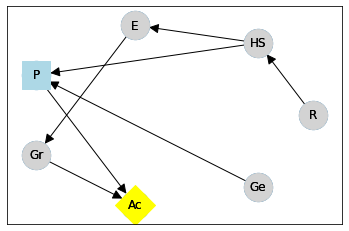

In [3]:
cid.draw()

To determine which nodes have positive value of information for the predictor model making a grade prediction (node 'P') in such a way as to maximise its accuracy ('Ac'):

In [4]:
pycid.admits_voi_list(cid, 'P')

['Gr', 'E', 'HS']

We can show this visually:

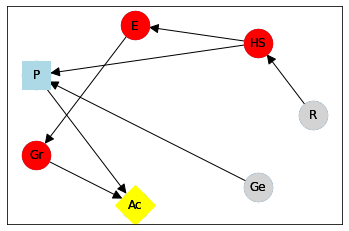

In [5]:
cid.draw_property(lambda node: pycid.admits_voi(cid, 'P', node))

Therefore, the prediction model would benefit from knowing the value of "High School', 'Education', and the student's true 'Grade' before making a grade prediction.

We can also ask whether an individual node offers positive value of information:

In [6]:
pycid.admits_voi(cid, 'P', 'HS')

True

In [7]:
pycid.admits_voi(cid, 'P', 'R')

False

## B) Quantitative VOI

We provide an example below to illustrate quantitative value of information

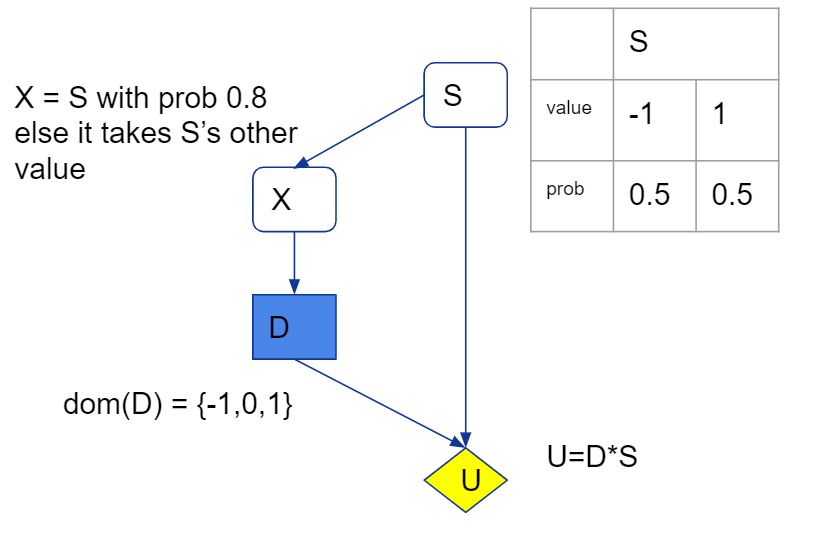

>Definition __Quantitative Value_of Information__: A node $X \in V \setminus Desc(D)$ in a single-decision SCIM $\mathcal{M}$ has VOI if $\mathcal{V}^*(\mathcal{M}_{X \not\rightarrow D}) < \mathcal{V}^*(\mathcal{M}_{X \rightarrow D})$ where $\mathcal{V}^*(\mathcal{M})$ is the maximum attainable utility in the model $\mathcal{M}$, $\mathcal{M}_{X \rightarrow D}$ is the model obtained by adding the edge $X \rightarrow D$ to $\mathcal{M}$, and $\mathcal{M}_{X \not\rightarrow D}$ is the model after that edge has been removed.

A CIM for this example is as follows:

In [8]:
cid = pycid.CID([("S", "X"), ("X", "D"), ("D", "U"), ("S", "U")], decisions=["D"], utilities=["U"])
cpd_s = pycid.UniformRandomCPD("S", [-1, 1])
# X takes the value of S with probability 0.8
cpd_x = pycid.StochasticFunctionCPD("X", lambda s: {s: 0.8}, domain=[-1, 1])
cpd_d = pycid.DecisionDomain("D", [-1, 0, 1])
cpd_u = pycid.FunctionCPD("U", lambda s, d: int(s) * int(d))
cid.add_cpds(cpd_s, cpd_x, cpd_d, cpd_u)

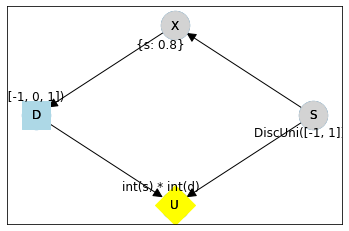

In [9]:
cid.draw()

We know from the graphical criterion that both X and S admit voi

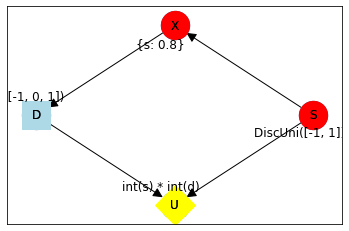

In [10]:
cid.draw_property(lambda node: pycid.admits_voi(cid, 'D', node))

Let's confirm this quantitatively:

We'll start with X because the CID already contains an edge $X \rightarrow D$

In [11]:
cid.impute_optimal_policy()

In [12]:
cid.expected_utility({})

0.6000000000000001

so $\mathcal{V}^*(\mathcal{M}_{X \rightarrow D}) = 0.6$   because if X takes S's true value (probability 0.8), the agent will play optimally and get utility 1, and if X takes S' other value (probability 0.2), the agent will play suboptimally and get utility -1

0.8*1 + 0.2(-1) = 0.6

Now let's remove the edge $X \rightarrow D$

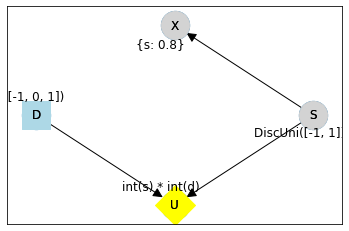

In [13]:
#we should remove the existing decision rule first because this assumes that there is an edge X -> D
cid.remove_all_decision_rules()
cid.remove_edge('X', 'D')
cid.draw()

In [14]:
cid.impute_optimal_policy()
cid.expected_utility({})

0.0

$\mathcal{V}^*(\mathcal{M}_{X \not\rightarrow D}) = 0$

This is as expected. S takes value 1 or -1 with equal probability and X is a noisy indicator of S. The agent's uility depends on the value of S but it cannot know which value it takes. Therefore any action -1, 0 or 1 returns expected utility 0

Therefore $\mathcal{V}^*(\mathcal{M}_{X \not\rightarrow D}) - \mathcal{V}^*(\mathcal{M}_{X \rightarrow D}) = 0.6$ and so in this paramaterisation of the CID, X does admit value of information. 

This expression can be queried directly with:

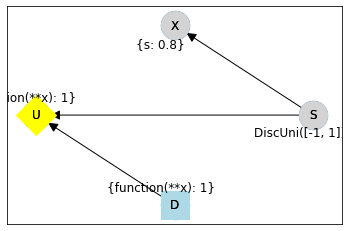

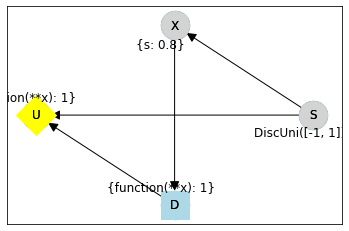

0.6000000000000001

In [15]:
pycid.quantitative_voi(cid, 'D', 'X')

We can follow the same reasoning for S:

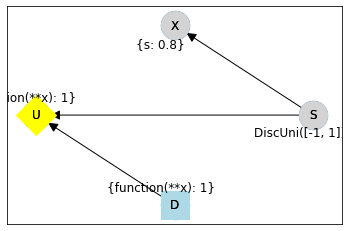

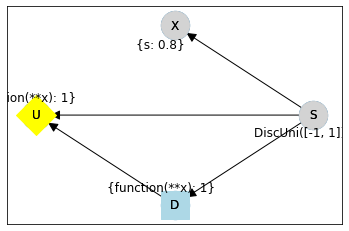

1.0

In [16]:
pycid.quantitative_voi(cid, 'D', 'S')

## C) Response Incentives

A variable has a __response incentive__ if a decision-maker benefits from making its decision causally responsive to the variable (AI:ACP)

Before we introduce the graphical criterion for a response incentive, we need to introduce the concept of a nonrequisite observation (Lauritzen and Nilsson, 2001) 

A __nonrequisite observation link__ in a single-decision CID $G$ is any edge $W \rightarrow D$ such that $W \perp U | (Pa_D ∪ {D} \setminus {W})$.
(where $U\in Desc(D)$)

>The __requisite graph__, $G^*$, of a single-decision CID $G$ is the result of removing from $G$ all nonrequisite observation links.

Note: this is the same as removing all edges from D to any of its parent nodes that do not admit positive value of information

Also note: a requisite graph is also known as a __minimal reduction__, __trimmed_graph__, or __d-reduction__.


Following from this, we arrive at the graphical criterion for a response incentive (AI:ACP): 

>A single-decision CID G admits a __response incentive__ on $X \in \textbf{V}$ if and only if the requisite graph $G^∗$ has a directed path $X \rightarrow D$.

To demonstrate this concept, we will again consider the __Grade prediction example__ (descibed above)

In [17]:
cid = pycid.CID([
    ('R', 'HS'),
    ('HS', 'E'),
    ('HS', 'P'),
    ('E', 'Gr'),
    ('Gr', 'Ac'),
    ('Ge', 'P'),
    ('P', 'Ac'),
    ],
    decisions=['P'],
    utilities=['Ac']
    )

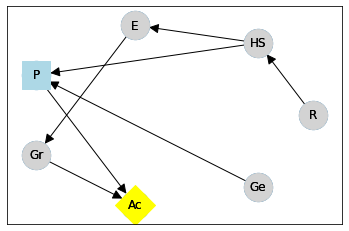

In [18]:
cid.draw()

To find all the nodes in this CID that admit a responce incentive:

In [19]:
pycid.admits_ri_list(cid, 'P')

['R', 'HS']

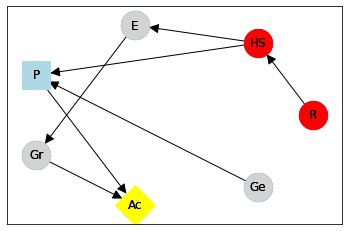

In [20]:
cid.draw_property(lambda node: pycid.admits_ri(cid, 'P', node))

Again, we can test whether an individual node admits a responce incentive:

In [21]:
pycid.admits_ri(cid, 'P', 'R')

True

AI:ACP argue that a response incentive on a sensitive attribute can be problematic from a fairness perspective. A decision is considered counterfactually unfair if a change to a sensitive attribute, such as race or gender, would change the decision. Therefore, a response incentive on a sensitve attribute indicates that counterfactual unfairness is incentivised; it implies that all optimal policies are counterfactually unfair. 

AI:ACP propose redesigning the grade-predictor by removing the predictor's access to knowledge about the student's high school ('HS'->'P') because this means that there will no longer be a response incentive on a sensitive attribute.

In [22]:
cid = pycid.CID([
    ('R', 'HS'),
    ('HS', 'E'),
    ('E', 'Gr'),
    ('Gr', 'Ac'),
    ('Ge', 'P'),
    ('P', 'Ac'),
    ],
    decisions=['P'],
    utilities=['Ac']
    )

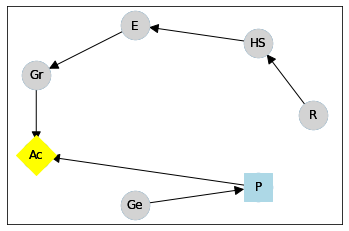

In [23]:
cid.draw_property(lambda node: pycid.admits_ri(cid, 'P', node))

After the change, we can see that no node in the CID for the system admits a response incentive!

## D) Value of Control

A variable has positive __value of control (VoC)__ if a decision-maker could benefit from choosing that variable's value.

Its graphical criterion (AI:ACP) is:

>A single-decision CID $G$ admits __positive value of control__ for a node $X \in V \setminus {D}$ if and only if there is a directed path $X \rightarrow U$ in the requisite graph $G^*$.

To demonstrate this incentive, we introduce another example from AI:ACP.

__Content recommendation example:__ _An AI algorithm has the task of recommending a series ries of posts to a user. The designers want the posts to match the user’s interests, to maximise the number of posts the user clicks on. However, they do not want the algorithm to present polarising content to manipulate the user into clicking more predicatably._

- O = Original user opinions
- I = Influences user opinions
- M = Model of original opinions
- P = Posts to show [decision node]
- C = Clicks [utility node]

In [24]:
cid = pycid.CID([
        ('O', 'M'),
        ('O', 'I'),
        ('M', 'P'),
        ('P', 'I'),
        ('I', 'C'),
        ('P', 'C'),
        ],
        decisions=['P'],
        utilities=['C']
        )

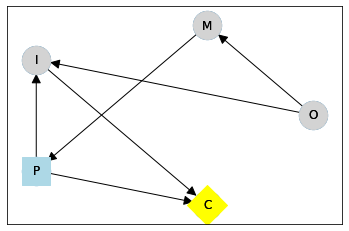

In [25]:
cid.draw()

We then can use similar functions to what we used for VoI and RI:

In [26]:
pycid.admits_voc_list(cid)

['O', 'M', 'I', 'C']

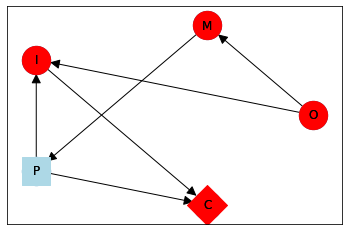

In [27]:
cid.draw_property(lambda node: pycid.admits_voc(cid, node))

### Instrumental Control Incentive

The final single-decision CID incentive that we shall introduce in this tutorial is the concept of an __instrumental_control_incentive__. The concept can be intuitively understood as follows. If the agent got to choose $D$ to influence $X$ independently of how $D$ influences other aspects of the environment, would that choice matter? In other words, is controlling $X$ instrumentally useful for maximising utility?

Its graphical criterion (AI:ACP) is:

>A single-decision CID $G$ admits an __instrumental_control_incentive__ for a node $X \in V$ if and only if $G$ has a directed path from the decision $D$ to a utility node $U \in \textbf{U}$ that passes through $X$.

Using the __content_reccomendation_example__ again to demonstrate this criterion:

In [28]:
cid = pycid.CID([
        ('O', 'M'),
        ('O', 'I'),
        ('M', 'P'),
        ('P', 'I'),
        ('I', 'C'),
        ('P', 'C'),
        ],
        decisions=['P'],
        utilities=['C']
        )

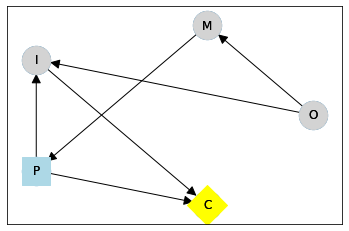

In [29]:
cid.draw()

We determine which nodes admit instrumental control incentives in the now familiar way:

In [30]:
pycid.admits_ici_list(cid, 'P')

['I', 'P', 'C']

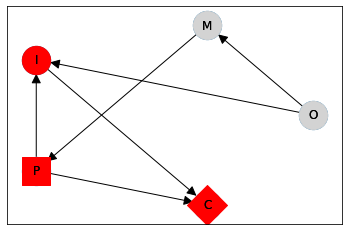

In [31]:
cid.draw_property(lambda node: pycid.admits_ici(cid, 'P', node))

We can understand from this that because "I (influenced user opinions)" has an instumental control incentive, the content reccomender may seek to influence that variable in order to attain utility. AI:ACP offer an alternative content reccomender design that avoids this undesirable behaviour. Instead of being rewarded for the true click through rate, the content reccomender is rewarded for the clicks it would be predicted to have, based on a separately trained model of the user's preferences. The modified CID for this changed model is the following:

- O = Original user opinions
- I = Influences user opinions
- M = Model of original opinions
- P = Posts to show [decision node]
- PC = Predicted Clicks [utility node]

In [32]:
cid = pycid.CID([
        ('O', 'M'),
        ('O', 'I'),
        ('M', 'P'),
        ('M', 'PC'),
        ('P', 'I'),
        ('P', 'PC'),
        ],
        decisions=['P'],
        utilities=['PC']
        )

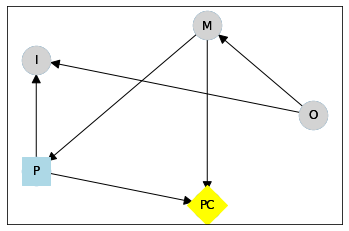

In [33]:
cid.draw()

We observe that 'PC' (Predicted clicks) still has an instumental control incentive so the content reccomender would still deliver desired content, but 'I' (Influnces user opinion) no longer has this incentive, as required. 

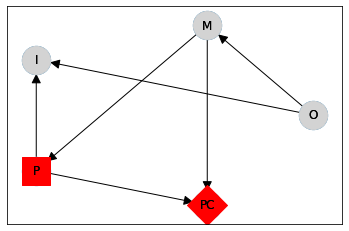

In [34]:
cid.draw_property(lambda node: pycid.admits_ici(cid, 'P', node))

### References

Lauritzen, S. L.; and Nilsson, D. 2001. Representing and Solving Decision Problems with Limited Information. Management Science .

Tom Everitt, Ryan Carey, Eric Langlois, Pedro Ortega, and Shane Legg. 2021.
Agent Incentives: a Causal Perspective. In Proceedings of the Thirty-Fifth AAAI
Conference on Artificial Intelligence, (AAAI-21).
